In [1]:
# using CuArrays # comment me out if you don't want to use GPU
using Flux, Flows
import Distributions: rand, logpdf
import PyPlot; const plt = PyPlot
using Tracker: update!

┌ Info: Recompiling stale cache file /home/sharan/.julia/compiled/v1.1/Flows/HDEsO.ji for Flows [b7844722-a0ec-11e9-22bc-51d568b73702]
└ @ Base loading.jl:1184
┌ Warning: Package Flows does not have MLToolkit in its dependencies:
│ - If you have Flows checked out for development and have
│   added MLToolkit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Flows
└ Loading MLToolkit into Flows from project dependency, future warnings for Flows are suppressed.


## Generate some data from a mixture of two Gaussians to use

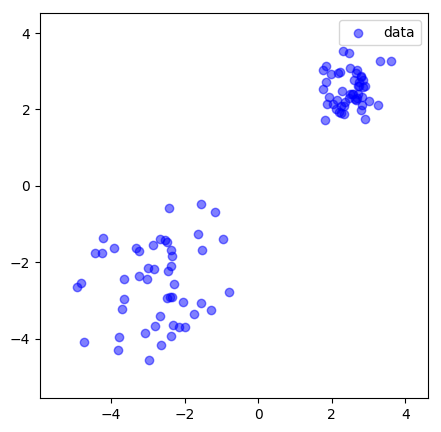

2×100 Array{Float32,2}:
 2.83241  2.37328  2.32756  2.24544  …  -1.63825  -3.78315  -2.41106 
 2.11381  2.1979   1.87504  1.91476     -1.27336  -3.95706  -0.576911

In [2]:
X = randn(Float32, 2, 100)
X[:,1:50] .*= 0.5
X[:,1:50] .+= 5.0
X .-= 2.5

function makeplot(x; xgen=nothing, logpdf2plot=nothing, contourevals=100)
    p = plt.figure(figsize=(5, 5))
    plt.scatter(x[1,:], x[2,:], c="blue", alpha=0.5, label="data")
    xgen == nothing || plt.scatter(xgen[1,:], xgen[2,:], c="red", alpha=0.5, label="samples")
    xlims = [extrema(x[1,:])...] + [-1, 1]
    ylims = [extrema(x[2,:])...] + [-1, 1]
    if logpdf2plot != nothing
        rangex = range(xlims..., length=contourevals)
        rangey = range(ylims..., length=contourevals)
        gridxy = [[xy...] for xy in Iterators.product(rangex, rangey)]
        gridx = map(xy -> xy[1], gridxy)
        gridy = map(xy -> xy[2], gridxy)
        gridz = exp.(logpdf2plot(hcat(gridxy[:]...) |> gpu)) |> cpu |> Flux.data
        gridz = reshape(gridz, size(gridx)...)
        plt.contour(gridx, gridy, gridz, alpha=0.5)
        plt.colorbar()
    end
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.legend()
    nothing
end

makeplot(X)

# Send data to GPU
X = X |> gpu

## Create a normalising flow by stacking multiple affine coupling layers

$$ f = f_1 \circ f_2 \circ \cdots \circ f_{N-1} \circ f_N : \mathcal{Z} \rightarrow \mathcal{X}$$

We assume base distribution is the unit Gaussian, i.e. $p_{\mathcal{Z}} = \mathcal{N}(0,1)$.

In [3]:
# Define a base distribution that is easy to work with GPU
struct MvNormal01
    dim::Int
end

# The constant below is a hack to make things work on GPU.
const LOG2PI32 = log(2Float32(pi))
logpdf(d::MvNormal01, x) = sum(-(LOG2PI32 .+ x .* x) ./ 2; dims=1)
rand(d::MvNormal01, n::Int=1) = randn(Float32, d.dim, n) |> gpu

rand (generic function with 214 methods)

In [14]:
DEPTH = 6
# initialize flow with dim 2 and depth 6
T = PlanarFlow(2, DEPTH)
base = MvNormal01(size(X, 1))

# A normalising flow is nothing but a transformation plus a base distribution
# Check `src/flows.jl` for the abstraction
flow = Flow(T, base)

# Create optimiser
opt = ADAM(2e-3)
ps = params(flow)
;

UndefVarError: UndefVarError: param not defined

## Define loss

$$\mathcal{L} = -\log p_{\mathcal{X}}(x) = -\left(\log p_{\mathcal{Z}}(f^{-1}(x)) + \log \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|\right),$$

where $f^{-1}: \mathcal{X} \rightarrow \mathcal{Z}$.

In [5]:
compute_loss(x) = -sum(logpdf(flow, x)) / size(x, 2)

compute_loss (generic function with 1 method)

## Run optimisation

In [6]:
niters = 2_000
timeused = @elapsed for iter = 1:niters
    iter % 10 == 0 && print(".")
    loss = compute_loss(X)
    gs = Tracker.gradient(() -> loss, ps)
    update!(opt, ps, gs)
    iter % 100 == 0 && println("($iter/$niters) done; loss=$(Flux.data(loss))")
end
println("done; $(timeused)s used")

..........(100/2000) done; loss=10.826067
..........(200/2000) done; loss=9.037216
..........(300/2000) done; loss=8.235604
..........(400/2000) done; loss=7.8612285
..........(500/2000) done; loss=7.6626344
..........(600/2000) done; loss=7.544281
..........(700/2000) done; loss=7.4538426
..........(800/2000) done; loss=7.3822017
..........(900/2000) done; loss=7.324397
..........(1000/2000) done; loss=7.275868
..........(1100/2000) done; loss=7.230659
..........(1200/2000) done; loss=7.1986675
..........(1300/2000) done; loss=7.1665816
..........(1400/2000) done; loss=7.1374836
..........(1500/2000) done; loss=7.1149263
..........(1600/2000) done; loss=7.096568
..........(1700/2000) done; loss=7.0770054
..........(1800/2000) done; loss=7.060857
..........(1900/2000) done; loss=7.0455956
..........(2000/2000) done; loss=7.033064
done; 23.935305971s used


## Draw samples

$$ z \sim \mathcal{N}(0,1) $$
$$ x = f(z) $$

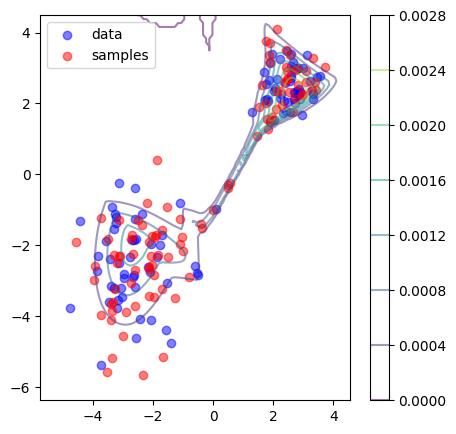

In [7]:
# Draw 100 samples from the normalising flow
Xgen = rand(flow, 100) |> cpu |> Flux.data

makeplot(X; xgen=Xgen, logpdf2plot=x -> logpdf(flow, x))